# Reading a Neon dataset/recording
In this tutorial, we will show how to load a single Neon recording downloaded from [Pupil Cloud](https://docs.pupil-labs.com/neon/pupil-cloud/) and give an overview of the data structure.

## Reading sample data
We will use a sample recording produced by the NCC Lab, called `OfficeWalk`. This project (collection of recordings on Pupil Cloud) contains two recordings and multiple enrichments and can be downloaded with the `get_sample_data()` function. The function returns a `Pathlib.Path` [(reference)](https://docs.python.org/3/library/pathlib.html#pathlib.Path) object pointing to the downloaded and unzipped directory. PyNeon accepts both `Path` and `string` objects but internally always uses `Path`.

In [1]:
from pyneon import get_sample_data, NeonDataset, NeonRecording

# Download sample data (if not existing) and return the path
sample_dir = get_sample_data("OfficeWalk")
print(sample_dir)

D:\GitHub\pyneon\data\OfficeWalk


The `OfficeWalk` data has the following structure:

```text
OfficeWalk
├── Timeseries Data
│   ├── walk1-e116e606
│   │   ├── info.json
│   │   ├── gaze.csv
│   │   └── ....
│   ├── walk2-93b8c234
│   │   ├── info.json
│   │   ├── gaze.csv
│   │   └── ....
|   ├── enrichment_info.txt
|   └── sections.csv
├── OfficeWalk_FACE-MAPPER_FaceMap
├── OfficeWalk_MARKER-MAPPER_TagMap_csv
└── OfficeWalk_STATIC-IMAGE-MAPPER_ManualMap_csv
```

The `Timeseries Data` folder contains what PyNeon refers to as a `NeonDataset`. It consists of two recordings, each with its own `info.json` file and data files. These recordings can be loaded either individually as a `NeonRecording` as a collective `NeonDataset`.

To load a `NeonDataset`, specify the path to the `Timeseries Data` folder:

In [2]:
dataset_dir = sample_dir / "Timeseries Data"
dataset = NeonDataset(dataset_dir)
print(dataset)

NeonDataset | 2 recordings


NeonDataset has a `recordings` attribute containing a list of `NeonRecording` objects. You can access individual recordings by index:

In [3]:
first_recording = dataset[0]
print(type(first_recording))
print(first_recording.recording_dir)

<class 'pyneon.recording.NeonRecording'>
D:\GitHub\pyneon\data\OfficeWalk\Timeseries Data\walk2-93b8c234


Alternatively, you can directly load a single `NeonRecording` by specifying the recording's folder path:

In [4]:
recording_dir = dataset_dir / "walk1-e116e606"
recording = NeonRecording(recording_dir)
print(type(recording))
print(recording.recording_dir)

<class 'pyneon.recording.NeonRecording'>
D:\GitHub\pyneon\data\OfficeWalk\Timeseries Data\walk1-e116e606


## Data and metadata of a NeonRecording
You can quickly get an overview of the metadata and contents of a `NeonRecording` by printing the object. The basic metadata (e.g., recording and wearer ID, recording start time and duration) and the path to available data will be displayed. At this point, the data is simply located from the recording's folder path, but it is not yet loaded into memory.

In [5]:
print(recording)


Recording ID: e116e606-5f3f-4d34-8727-040b8762cef8
Wearer ID: bcff2832-cfcb-4f89-abef-7bbfe91ec561
Wearer name: Qian
Recording start time: 2024-08-30 17:37:01.527000
Recording duration: 98.213s
                  exist              filename                                                                                  path
3d_eye_states      True     3d_eye_states.csv     D:\GitHub\pyneon\data\OfficeWalk\Timeseries Data\walk1-e116e606\3d_eye_states.csv
blinks             True            blinks.csv            D:\GitHub\pyneon\data\OfficeWalk\Timeseries Data\walk1-e116e606\blinks.csv
events             True            events.csv            D:\GitHub\pyneon\data\OfficeWalk\Timeseries Data\walk1-e116e606\events.csv
fixations          True         fixations.csv         D:\GitHub\pyneon\data\OfficeWalk\Timeseries Data\walk1-e116e606\fixations.csv
gaze               True              gaze.csv              D:\GitHub\pyneon\data\OfficeWalk\Timeseries Data\walk1-e116e606\gaze.csv
imu          

As seen in the output, this recording includes all data files except the scene video and its metadata because we downloaded only the "Timeseries Data" instead of " "Timeseries Data + Scene Video" from Pupil Cloud. For processing video, refer to the [Neon video tutorial](video.ipynb).

Individual data streams can be accessed as properties of the `NeonRecording` object. For example, the gaze data can be accessed as `recording.gaze`, and upon accessing, the tabular data is loaded into memory. On the other hand, if you try to access unavailable data like the video, it will simply return `None` and a warning message.

In [6]:
# Gaze and fixation data are available
gaze = recording.gaze
print(f"recording.gaze is {gaze}")
fixations = recording.fixations
print(f"recording.fixations is {fixations}")

# Video is not available
video = recording.video
print(f"recording.video is {video}")

recording.gaze is <pyneon.stream.NeonGaze object at 0x000001B2167FC830>
recording.fixations is <pyneon.events.NeonFixations object at 0x000001B236FA6DB0>
recording.video is None


D:\GitHub\pyneon\pyneon\recording.py:271: UserWarning: Scene video not loaded because not all video-related files (video, scene_camera.json, world_timestamps.csv) are found.
  warnings.warn(


PyNeon reads tabular CSV file into specialized classes (e.g., gaze.csv to `NeonGaze`) which all have a `data` attribute that holds the tabular data as a `pandas.DataFrame` [(reference)](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). Depending on the nature of the data, such classes could be of `NeonStream` or `NeonEV` super classes. `NeonStream` contains (semi)-continuous data streams, while `NeonEV` (dubbed so to avoid confusion with the `NeonEvent` subclass that holds data from `events.csv`) contains sparse event data.

The class inheritance relationship is as follows:

```text
NeonTabular
├── NeonStream
│   ├── NeonGaze
│   ├── NeonEyeStates
│   └── NeonIMU
└── NeonEV
    ├── NeonBlinks
    ├── NeonSaccades
    ├── NeonFixations
    └── NeonEvents
```

## Data as dataframes

The essence of `NeonTabular` is the `data` attribute—a `pandas.DataFrame`. This is a common data structure in Python for handling tabular data. For example, you can print the first 5 rows of the gaze data by calling `gaze.data.head()`, and inspect the data type of each column by calling `gaze.data.dtypes`.

In [7]:
print(gaze.data.head())
print(gaze.data.dtypes)

                     gaze x [px]  gaze y [px]  worn  fixation id  blink id  \
timestamp [ns]                                                               
1725032224852161732     1067.486      620.856     1            1      <NA>   
1725032224857165732     1066.920      617.117     1            1      <NA>   
1725032224862161732     1072.699      615.780     1            1      <NA>   
1725032224867161732     1067.447      617.062     1            1      <NA>   
1725032224872161732     1071.564      613.158     1            1      <NA>   

                     azimuth [deg]  elevation [deg]  
timestamp [ns]                                       
1725032224852161732      16.213030        -0.748998  
1725032224857165732      16.176285        -0.511733  
1725032224862161732      16.546413        -0.426618  
1725032224867161732      16.210049        -0.508251  
1725032224872161732      16.473521        -0.260388  
gaze x [px]        float64
gaze y [px]        float64
worn                 

In [8]:
print(fixations.data.head())
print(fixations.data.dtypes)

                      fixation id   end timestamp [ns]  duration [ms]  \
start timestamp [ns]                                                    
1725032224852161732             1  1725032225007283732            155   
1725032225027282732             2  1725032225282527732            255   
1725032225347526732             3  1725032225617770732            270   
1725032225667907732             4  1725032225798022732            130   
1725032225833015732             5  1725032225958137732            125   

                      fixation x [px]  fixation y [px]  azimuth [deg]  \
start timestamp [ns]                                                    
1725032224852161732          1069.932          614.843      16.369094   
1725032225027282732           906.439          538.107       5.878844   
1725032225347526732           694.843          533.982      -7.781338   
1725032225667907732           572.983          488.800     -15.679003   
1725032225833015732           601.861          491

PyNeon performs the following preprocessing when reading the CSV files:
1. Removes the redundant `section id` and `recording id` columns that are present in the raw CSVs.
2. Sets the `timestamp [ns]` (or `start timestamp [ns]` for most event files) column as the DataFrame index.
3. Automatically assigns appropriate data types to columns. For instance, `Int64` type is assigned to timestamps, `Int32` to event IDs (blink/fixation/saccade ID), and `float64` to float data (e.g. gaze location, pupil size).

Just like any other `pandas.DataFrame`, you can access individual rows, columns, or subsets of the data using the standard indexing and slicing methods. For example, `gaze.data.iloc[0]` returns the first row of the gaze data, and `gaze.data['gaze x [px]']` returns the gaze x-coordinate column.

In [9]:
print(f"First row of gaze data:\n{gaze.data.iloc[0]}\n")
print(f"All gaze x values:\n{gaze.data['gaze x [px]']}")

First row of gaze data:
gaze x [px]        1067.486
gaze y [px]         620.856
worn                    1.0
fixation id             1.0
blink id               <NA>
azimuth [deg]      16.21303
elevation [deg]   -0.748998
Name: 1725032224852161732, dtype: Float64

All gaze x values:
timestamp [ns]
1725032224852161732    1067.486
1725032224857165732    1066.920
1725032224862161732    1072.699
1725032224867161732    1067.447
1725032224872161732    1071.564
                         ...   
1725032319717194732     800.364
1725032319722198732     799.722
1725032319727194732     799.901
1725032319732194732     796.982
1725032319737194732     797.285
Name: gaze x [px], Length: 18769, dtype: float64


## Useful attributes and methods for NeonStream and NeonEV
On top of analyzing `data` with `pandas.DataFrame` attributes and methods, you may also use attributes and methods of the `NeonStream` and `NeonEV` instances containing the `data` to facilitate Neon-specific data analysis. For example, `NeonStream` class has a `ts` property that allows quick access of all timestamps in the data as a `numpy.ndarray` [(reference)](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html).

Useful as they are, UTC timestamps in nanoseconds are usually too large for human comprehension. Often we would want to simply know what is the relative time for each data point since the stream start (which is different from the recording start). In PyNeon, this is referred to as `times` and is in seconds. You can access it as a `numpy.ndarray` by calling the `times` property.


In [10]:
print(gaze.ts)
print(gaze.times)

[1725032224852161732 1725032224857165732 1725032224862161732 ...
 1725032319727194732 1725032319732194732 1725032319737194732]
[0.0000000e+00 5.0040000e-03 1.0000000e-02 ... 9.4875033e+01 9.4880033e+01
 9.4885033e+01]


Timestamps (UTC, in ns) and relative time (relative to the stream start, in s) are thus the two units of time that are most commonly used in PyNeon. For example, you can crop the stream by either timestamp or relative time by calling the `crop()` method. The method takes two arguments: `start` and `end`:

In [11]:
# Last data time of the original gaze data
print(gaze.times[-1])

# Crop the gaze data to the first 10 seconds
gaze_cropped = gaze.crop(0, 10, by="time")  # Crop by time
print(gaze_cropped.times[-1])

94.885033
9.999289


There are many other attributes and methods available for `NeonStream` and `NeonEV` classes. For a full list, refer to the [API reference](https://ncc-brain.github.io/PyNeon/reference/data.html). We will also cover some of them in the following tutorials (e.g., [interpolation and concatenation of streams](interpolate_and_concat.ipynb)).

## Data streams and events

Up to this point, PyNeon simply reads and re-organizes the raw .csv files. Let's plot some samples from the `gaze` and `eye_states` streams and a saccade from the `saccades` events.

saccade id                                2.0
end timestamp [ns]      1725032225347526656.0
duration [ms]                            65.0
amplitude [px]                      228.36139
amplitude [deg]                     14.676102
mean velocity [px/s]              3685.269894
peak velocity [px/s]              5411.775481
Name: 1725032225282527732, dtype: Float64


TypeError: unhashable type: 'numpy.ndarray'

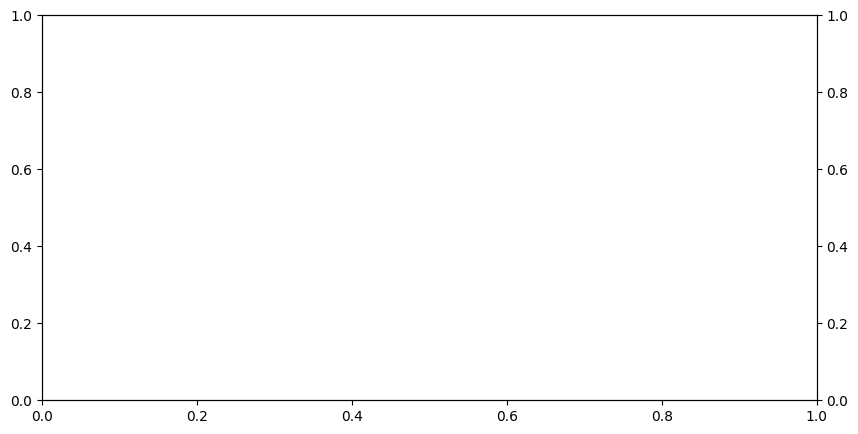

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

gaze_color = "royalblue"
gyro_color = "darkorange"

imu = recording.imu
fixations = recording.saccades

# Create a figure
fig, ax = plt.subplots(figsize=(10, 5))
ax2 = ax.twinx()
ax.yaxis.label.set_color(gaze_color)
ax2.yaxis.label.set_color(gyro_color)

# Visualize the 2nd saccade
saccade = fixations.data.iloc[1]
print(saccade)
ax.axvspan(saccade.index.values, saccade["end timestamp [ns]"], color="lightgray")
ax.text(
    (saccade.index.values + saccade["end timestamp [ns]"]) / 2,
    1050,
    "Saccade",
    horizontalalignment="center",
)

# Visualize gaze x and pupil diameter left
sns.scatterplot(
    ax=ax,
    data=gaze.data.head(100),
    x=gaze.data.index,
    y="gaze x [px]",
    color=gaze_color,
)
sns.scatterplot(
    ax=ax2,
    data=imu.data.head(60),
    x=imu.data.index,
    y="gyro x [deg/s]",
    color=gyro_color,
)

It's apparent that at the beginning of the recording, there are some missing data points in both the `gaze` and `imu` streams. This is presumably due to the time it takes for the sensors to start up and stabilize. We will show how to handle missing data using resampling in the next tutorial. For now, it's important to be aware of these gaps and that it will require great caution to assume the data is continuously and equally sampled.

PyNeon also calculates the effective (as opposed to the nominal) sampling frequency of each stream by dividing the number of samples by the duration of the recording.

In [ ]:
print(
    f"Gaze: nominal sampling frequency = {gaze.sampling_freq_nominal}, "
    f"effective sampling frequency = {gaze.sampling_freq_effective}"
)
print(
    f"IMU: nominal sampling frequency = {recording.imu.sampling_freq_nominal}, "
    f"effective sampling frequency = {recording.imu.sampling_freq_effective}"
)

## Visualizing gaze heatmap
Finally, we will show how to plot a heatmap of the gaze/fixation data.

In [ ]:
recording.plot_distribution()

we can neatly see that the recorded data shows a centre-bias, which is a well-known effect from eye statistics. In y, we can see that fixations tend to occur below the horizon, which is indicative of a walking task where a participant looks at the floor in front of them more often